In [1]:
import os, sys
import argparse
import numpy as np
from collections import defaultdict
import json
import time
import multiprocessing
import copy
import os.path as osp
# from utils import IdGenerator, id2rgb
import pdb
import torch
try:
    import PIL.Image     as Image
except:
    print("Failed to import the image processing packages.")
    sys.exit(-1)
from pycocotools.coco import COCO
import numpy as np
# import skimage.io as io
import pylab

In [2]:
# stage ='val'  #train or val'
stage ='train'  #'train or val'

## Load json

In [5]:
inst_gt_json_file = "../datasets/lvis/annotations/lvis_v0.5_"+stage+".json"
data_path = '../datasets/images/'+stage+'2017'
with open(inst_gt_json_file, 'r') as f:
    inst_gt = json.load(f)

In [6]:
inst_gt.keys()

dict_keys(['images', 'info', 'annotations', 'categories', 'licenses'])

## Sorted by instances number

In [8]:
sorted_inst = sorted(inst_gt['categories'], key=lambda k: k['instance_count'], reverse=True) 
sorted_instance_count = [item['instance_count'] for item in sorted_inst]
sorted_class_name = [item['name'] for item in sorted_inst]
sorted_frequency = [item['frequency'] for item in sorted_inst]

In [9]:
from collections import defaultdict
num_classses = len(inst_gt['categories'])
sorted_instance_count_dict = defaultdict(int)
for i in range(1,num_classses+1):
    sorted_instance_count_dict[int(i)] = sorted_instance_count[i-1]
# json.dump(sorted_instance_count_dict, open(os.path.join('../datasets/lvis/annotations/lvis_trainval_1230_cat_num.json'), 'w'))

## Draw distribution 

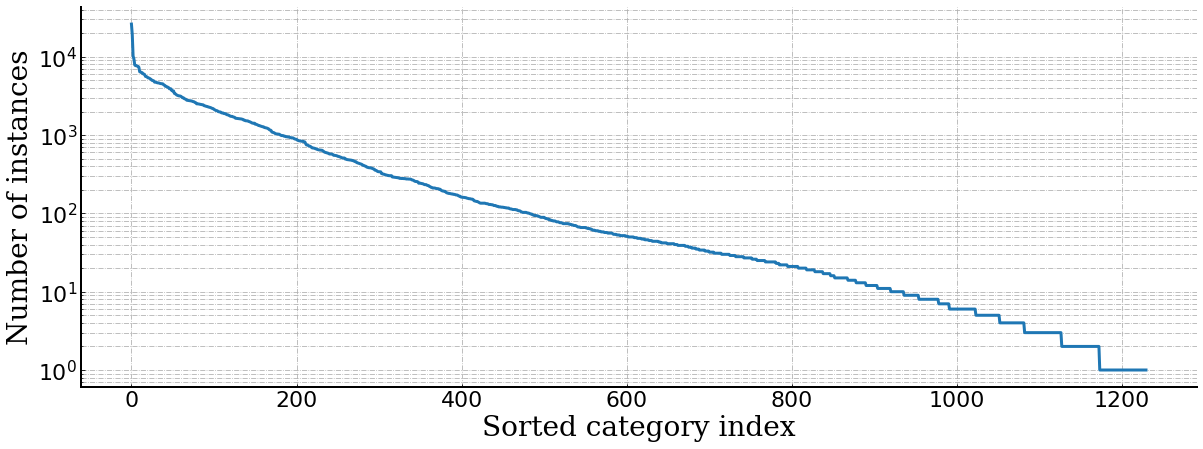

In [10]:
import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.ticker import  MultipleLocator
# matplotlib.use('Agg')

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
pylab.rcParams['figure.figsize'] = (20.0, 7.0)

x=range(len(sorted_instance_count))
y=sorted_instance_count

fig = plt.figure()
ax = fig.gca()

ymajorLocator = MultipleLocator(30000)     
yminorLocator = MultipleLocator(15000)       
ax.yaxis.set_major_locator(ymajorLocator)       
ax.yaxis.set_minor_locator(yminorLocator)

plt.plot(x,y, linewidth=3.0)

plt.yscale('log') #choose log or not
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

font1 = {'family':'serif','weight': 'normal','size': 28}
ax.set_xlabel('Sorted category index', font1)
ax.set_ylabel('Number of instances', font1)
# plt.legend(frameon=False)

plt.grid(linestyle='-.',which='both')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2);
ax.spines['left'].set_linewidth(2);

# plt.savefig('log_train.pdf',format='pdf',bbox_inches='tight')
# plt.savefig('norm_val.eps',format='eps',bbox_inches='tight')

## Show an example

In [11]:
import torch
import torchvision


min_keypoints_per_image = 10


def _count_visible_keypoints(anno):
    return sum(sum(1 for v in ann["keypoints"][2::3] if v > 0) for ann in anno)


def _has_only_empty_bbox(anno):
    return all(any(o <= 1 for o in obj["bbox"][2:]) for obj in anno)


def has_valid_annotation(anno):
    # if it's empty, there is no annotation
    if len(anno) == 0:
        return False
    # if all boxes have close to zero area, there is no annotation
    if _has_only_empty_bbox(anno):
        return False
    # keypoints task have a slight different critera for considering
    # if an annotation is valid
    if "keypoints" not in anno[0]:
        return True
    # for keypoint detection tasks, only consider valid images those
    # containing at least min_keypoints_per_image
    if _count_visible_keypoints(anno) >= min_keypoints_per_image:
        return True
    return False

class COCODataset(torchvision.datasets.coco.CocoDetection):
    def __init__(self, root, ann_file, remove_images_without_annotations=False):
        super(COCODataset, self).__init__(root, ann_file)
        self.ids = sorted(self.ids)

        # filter images without detection annotations
        if remove_images_without_annotations:
            ids = []
            for img_id in self.ids:
                ann_ids = self.coco.getAnnIds(imgIds=img_id, iscrowd=None)
                anno = self.coco.loadAnns(ann_ids)
                if has_valid_annotation(anno):
                    ids.append(img_id)
            self.ids = ids

        self.categories = {cat['id']: cat['name'] for cat in self.coco.cats.values()}

#         self.json_category_id_to_contiguous_id = {
#             v: i + 1 for i, v in enumerate(self.coco.getCatIds())
#         }
#         self.contiguous_category_id_to_json_id = {
#             v: k for k, v in self.json_category_id_to_contiguous_id.items()
#         }
        self.id_to_img_map = {k: v for k, v in enumerate(self.ids)}
        self.img_to_id_map = {k: v for v, k in self.id_to_img_map.items()}

#         self._transforms = transforms
        
    def __getitem__(self, idx):
        img, anno = super(COCODataset, self).__getitem__(idx)
        return img, anno
    
    def get_img_info(self, index):
        img_id = self.id_to_img_map[index]
        img_data = self.coco.imgs[img_id]
        return img_data
    
coco = COCODataset(data_path,inst_gt_json_file, True)

loading annotations into memory...
Done (t=15.96s)
creating index...
index created!


In [23]:
# get one image by id
get_id = 1412
ori_img, gt_anno = coco[get_id]

In [24]:
# Step1: get img_id, h, w 
"""
img_id = gt_anno[0]['image_id']
img = next(item for item in inst_gt['images'] if item['id']==img_id)
"""
# equals to
img = coco.get_img_info(get_id)
# img_name = img['file_name']
# img_path = osp.join('../dataset/coco/images/val2017',img_name)
h = img['height']; w = img['width']
# print(img)

# Step2: transfer 'not_exhaustive_category_ids' and 'neg_category_ids' to names
not_exhaustive_category_names = []
neg_category_names = []
for i in img['not_exhaustive_category_ids']:
    not_exhaustive_category_names.append(next(item for item in inst_gt['categories'] if item['id']==i)['name'])
for i in img['neg_category_ids']:
    neg_category_names.append(next(item for item in inst_gt['categories'] if item['id']==i)['name'])
# print('not_exhaustive_category_names',not_exhaustive_category_names)
# print('neg_category_names',neg_category_names)

# Step3: transfer the annotation's format to `list'
inst_polys = []
inst_boxes = []
inst_cat_ids = []
inst_cat_names = []
for i in gt_anno:
    inst_polys.append(i['segmentation'])
    inst_boxes.append(i['bbox'])
    inst_cat_ids.append(i['category_id'])
    inst_cat_names.append(coco.categories[i['category_id']])
#     inst_cat_names.append(next(item for item in inst_gt['categories'] if item['id']==i['category_id'])['name'])

# print('inst_cat_names in img',inst_cat_names)

## Visualization

In [25]:
def compute_colors_for_labels(labels):
    """
    Simple function that adds fixed colors depending on the class
    """
    palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
    colors = labels[:, None] * palette
    colors = (colors % 255).numpy().astype("uint8")
    return colors

In [28]:
not_exhaust_label_info = 'NOT EXHAUSTIVE LABELS:'
if len(not_exhaustive_category_names)==0:
    not_exhaust_label_info +='none'
else:
    i = 0
    for item in not_exhaustive_category_names:
        if i%1==0:
            not_exhaust_label_info+='\n'
        not_exhaust_label_info = not_exhaust_label_info+item+(26-len(item))*' '        
        i+=1
        
neg_label_info = 'NEGATIVE LABELS:'
if len(neg_category_names)==0:
    neg_label_info+='none'
else:
    i = 0   
    for item in neg_category_names:
        if i%1==0:
            neg_label_info+='\n'
        neg_label_info = neg_label_info+item+(10-len(item))*' '
        i+=1

annotated_label_info = 'ANNOTATED LABELS:'

i = 0
for item in set(inst_cat_names):
    if i%1==0:
        annotated_label_info+='\n'
    annotated_label_info = annotated_label_info+item+(26-len(item))*' '        
    i+=1
        

Text(437, 370, 'NEGATIVE LABELS:\nstrainer  \nmanhole   \nbriefcase \nhat       \nkite      \ncabana    \nambulance \nwall_socket\ncomputer_keyboard\ndumpster  \npolar_bear\ngiraffe   ')

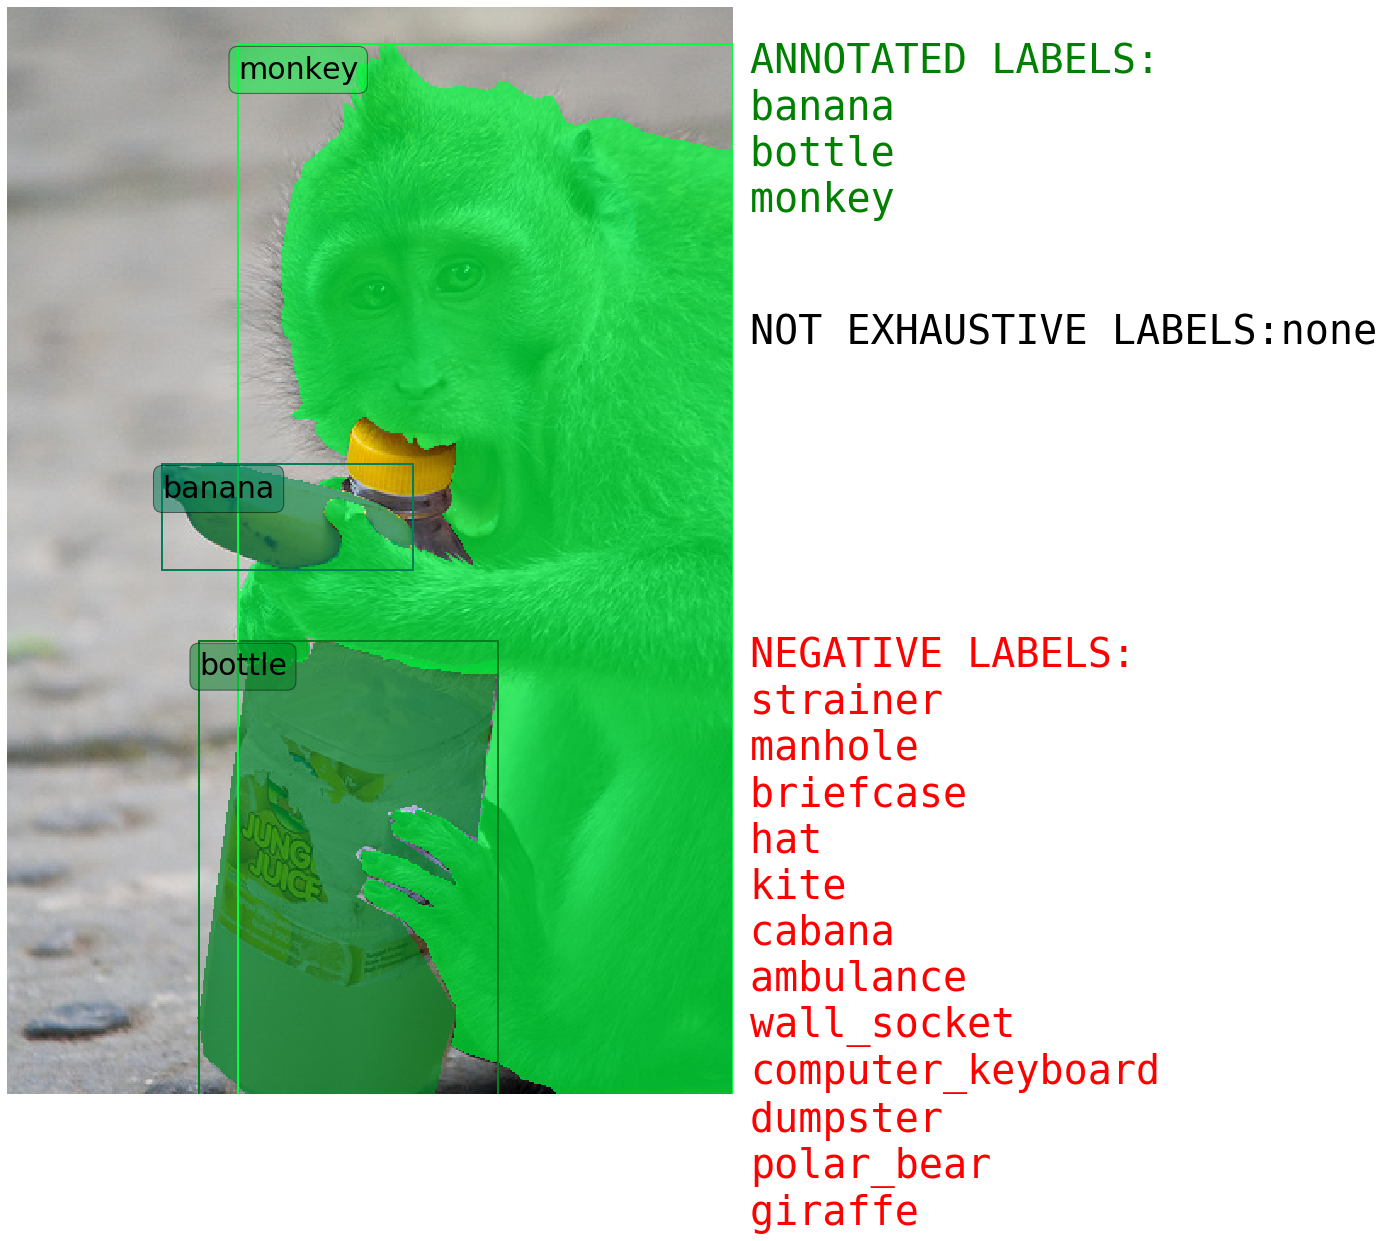

In [29]:
from cocoapi.PythonAPI.pycocotools.mask import frPyObjects
from cocoapi.PythonAPI.pycocotools.mask import decode, merge
matplotlib.use('Agg')
fig = plt.figure(figsize=(25,20))
plt.imshow(ori_img)
plt.axis('off')
currentAxis = plt.gca()

color_label = torch.arange(1,len(inst_cat_ids)+1).long()
colors = compute_colors_for_labels(color_label).tolist()    
    
    
for bbox, inst_poly, color, cat_name in zip(inst_boxes, inst_polys, colors, inst_cat_names):
    color = [item/255 for item in color]
#     print(color)
    coords = (bbox[0], bbox[1]), bbox[2], bbox[3]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    display_txt = '%s'%(cat_name)
#     currentAxis.text(bbox[0], bbox[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})  
    currentAxis.text(bbox[0], bbox[1]+20, display_txt,bbox={'facecolor':color, 'alpha':0.5,'boxstyle':'round'},
                             fontsize=30) 
    
    rles = frPyObjects(inst_poly, h, w )
    for rle in rles:
        rle["counts"] = rle["counts"].decode("utf-8")
    final_rle = merge(rles)
    mask = decode(final_rle)
    m = mask>0
#     color_mask = np.random.random((1,3)).tolist()[0]
    img = np.ones( (m.shape[0], m.shape[1], 3) )        
    img[:,:,:] = color
    currentAxis.imshow(np.dstack( (img, m*0.7) ))
    
plt.text(w+10,20,annotated_label_info,fontsize=40,family = "monospace", color = "g", weight = "light",
         verticalalignment="top",horizontalalignment="left",)  

plt.text(w+10,180,not_exhaust_label_info,fontsize=40,family = "monospace", color = "black", weight = "light",
         verticalalignment="top",horizontalalignment="left",)    

plt.text(w+10,370,neg_label_info,fontsize=40,family = "monospace", color = "r", weight = "light",
         verticalalignment="top",horizontalalignment="left") 

# plt.savefig('img.png',format='png')
# plt.savefig('img.pdf',format='pdf',bbox_inches='tight')